In [377]:
import requests
import json
import seaborn as sns
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib import figure
import pandas as pd
import numpy as np


In [381]:
def smhi_api_python_wrapper_json(latitude : float, longitude : float ) -> dict:
    
    """
    Simple wrapper to retrieve weather information from SMHI for the next 72 hours.
    
    :param latitude : The latitude of the area where weather information is desired from.
    :param longitude : The latitude of the area where weather information is desired from.
    :return JSON file. 
    
    """
    
    try:
   
        if not all(isinstance(i,float) for i in [latitude,longitude]):
            return 'Failed. Long/Lat must be a float value'
        
        smhi_request = requests.get(f"https://opendata-download-metfcst.smhi.se/api/category/pmp3g/version/2/geotype/point/lon/{longitude}/lat/{latitude}/data.json")
        smhi_request_json = smhi_request.json()
        
    except Exception as e:
        return print(e)
        
    return smhi_request_json
        

def return_parsed_df(smhi_request_json : dict) -> pd.DataFrame:
    
    """
   
    Takes a JSON file as input and returns a dataframe with all key pair values in the parameters dictionary. 
    
    :param request_json : JSON with the weather information. 
    :return Pandas DataFrame 
    
    """
    
    data_list = list()
    parameters_list = smhi_request_json['timeSeries'][0]['parameters']
    name_list = [x['name'] for x in parameters_list]
    
    for i in range(len(smhi_request_json['timeSeries'])):
        
        time = smhi_request_json['timeSeries'][i]['validTime']
        datetime_weather = datetime.strptime(time, "%Y-%m-%dT%H:%M:%SZ")
        day_hour = datetime_weather.strftime('%A %H:00')
        
        parameters_list = smhi_request_json['timeSeries'][i]['parameters']
        name_list = [x['name'] for x in parameters_list]
        name_list.append('DayHour')
        values_list = [x['values'][0] for x in parameters_list]
        values_list.append(day_hour)
        data_list.append(values_list)
        
        
    weather_dataframe = pd.DataFrame(data_list)
    weather_dataframe.columns = name_list
    
    # Extreme values are replaced with the median temperature. 
    weather_dataframe.t = np.where(weather_dataframe.t > 50, weather_dataframe.t.median(),weather_dataframe.t)
    
    return weather_dataframe
        
    
    


In [382]:
smhi_request_json = smhi_api_python_wrapper_json(59.0,18.0) # Stockholm
weather_df = return_parsed_df(smhi_request_json)

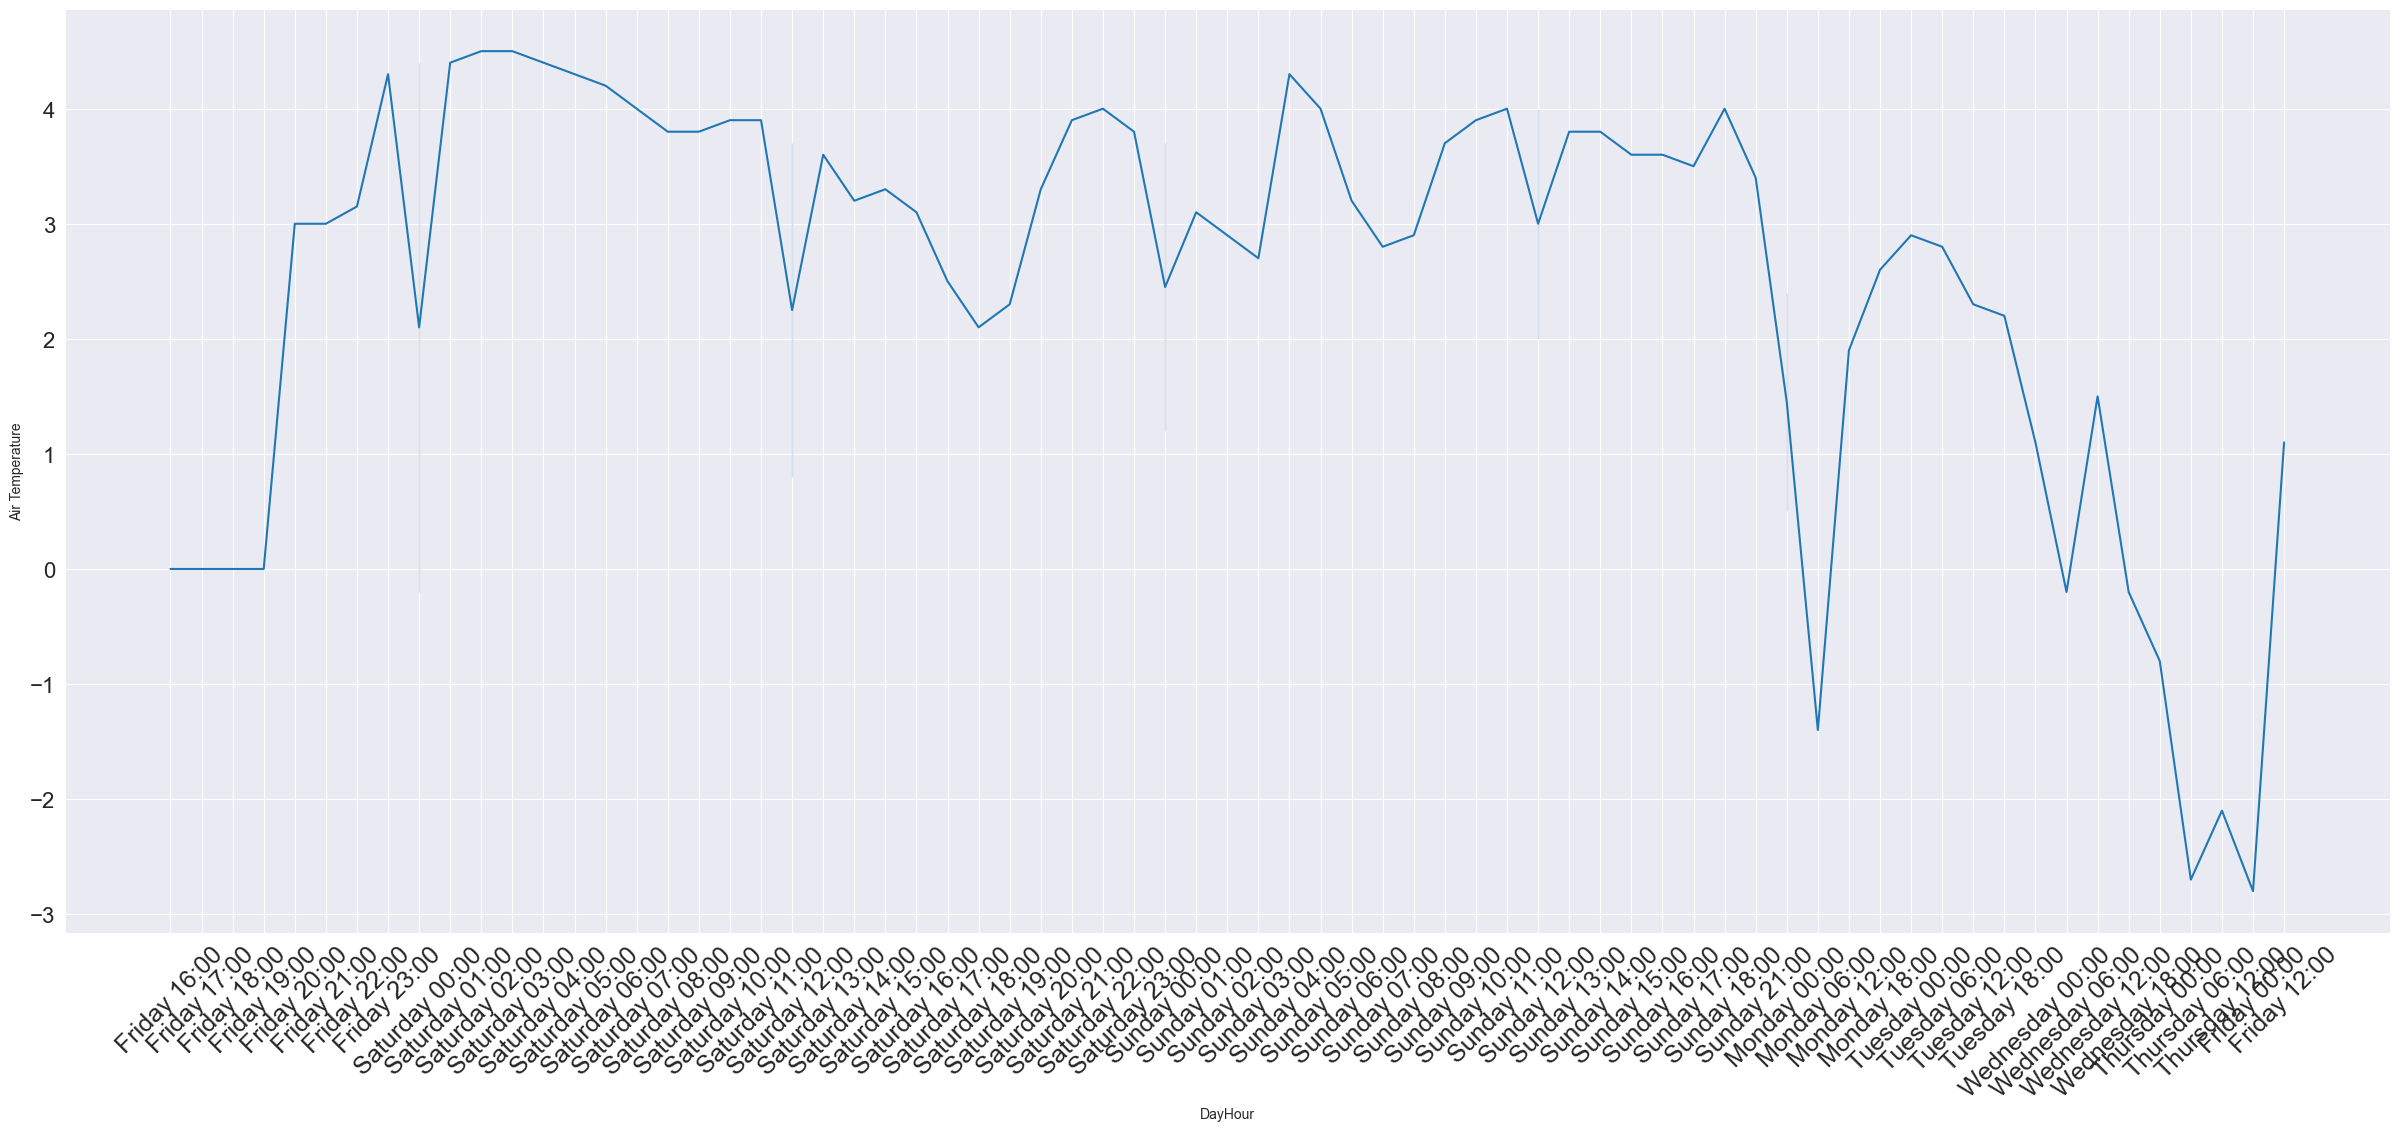

In [385]:
plt.figure(figsize=(30, 12))
sns.set_style("darkgrid")
sns.lineplot(data = weather_df, y = 't', x = 'DayHour', markers = True)
plt.xticks(rotation=45,fontsize=18, );
plt.yticks(fontsize=16);
plt.ylabel('Air Temperature');